<a href="https://colab.research.google.com/github/Bensonsoh1189/IE4483/blob/main/Pre_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import shutil
from google.colab import files

# Manually upload your dataset
uploaded = files.upload()

# Get the uploaded file name dynamically
ZIP_FILE = list(uploaded.keys())[0]
print(f"Uploaded file name: {ZIP_FILE}")

# Save the uploaded file directly to /content
TEMP_ZIP_PATH = f"/content/{ZIP_FILE}"

# Save the uploaded file from the byte stream to the content directory
with open(TEMP_ZIP_PATH, 'wb') as f:
    f.write(uploaded[ZIP_FILE])

print(f"✅ Uploaded file saved at: {TEMP_ZIP_PATH}")

# Clear the extraction path to remove any old data
EXTRACT_PATH = "/content/extracted_data"
if os.path.exists(EXTRACT_PATH):
    shutil.rmtree(EXTRACT_PATH)
os.makedirs(EXTRACT_PATH, exist_ok=True)
print("✅ Cleared previous extraction data!")

# Extract ZIP file from temporary location
try:
    with zipfile.ZipFile(TEMP_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ Dataset extracted!")
except FileNotFoundError:
    print(f"❌ File not found: {TEMP_ZIP_PATH}. Please check the uploaded file name.")

# Refresh the list of subdirectories after extraction
SUBDIRS = os.listdir(EXTRACT_PATH)

# Dynamically detect the correct input path containing class folders
def find_input_path(base_path):
    for root, dirs, files in os.walk(base_path):
        # Check if the current directory contains subdirectories (class folders)
        if dirs:
            return root
    return base_path

# Find the path containing the class folders dynamically
INPUT_PATH = find_input_path(EXTRACT_PATH)
print(f"✅ Using dataset path: {INPUT_PATH}")

# Verify class folders
class_folders = [d for d in os.listdir(INPUT_PATH) if os.path.isdir(os.path.join(INPUT_PATH, d))]
print("📂 Class Folders:", class_folders)


Saving Dataset_Visualization.zip to Dataset_Visualization.zip
Uploaded file name: Dataset_Visualization.zip
✅ Uploaded file saved at: /content/Dataset_Visualization.zip
✅ Cleared previous extraction data!
✅ Dataset extracted!
✅ Using dataset path: /content/extracted_data
📂 Class Folders: ['Dataset_Visualization']


In [ ]:
import shutil

AUGMENTED_PATH = "/content/augmented_dataset"

# Delete the existing augmented dataset folder to start fresh
shutil.rmtree(AUGMENTED_PATH, ignore_errors=True)

# Recreate the empty folder
os.makedirs(AUGMENTED_PATH)

print("✅ Cleaned up the augmented dataset folder.")


✅ Cleaned up the augmented dataset folder.


In [ ]:
import shutil
import os

PROCESSED_PATH = "/content/processed_dataset"

# Delete the existing processed dataset folder
shutil.rmtree(PROCESSED_PATH, ignore_errors=True)

# Recreate the train, val, test folders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(PROCESSED_PATH, split))

print("✅ Cleaned up the processed dataset folder.")


✅ Cleaned up the processed dataset folder.


In [ ]:
import os
import shutil
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# Global configurations
IMG_SIZE = (224, 224)
NUM_AUGMENTED = 1
SPLIT_PATH = "/content/split_dataset"
EXTRACT_PATH = "/content/extracted_data"
AUGMENTED_PATH = "/content/augmented_dataset/train"
RAW_DATASET_PATH = "/content/dataset"
splits = ['train', 'val', 'test']
ratios = [0.8, 0.1, 0.1]
IMG_EXTS = (".jpg", ".jpeg", ".png")

# Preprocessing function (Grayscale and Resize)
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, IMG_SIZE)
    return img

# Clear previous data (if exists)
for path in [SPLIT_PATH, AUGMENTED_PATH, RAW_DATASET_PATH]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

# Preprocess and save images before splitting
for root, dirs, files in os.walk(EXTRACT_PATH):
    for class_name in dirs:
        class_path = os.path.join(root, class_name)
        preprocessed_path = os.path.join(RAW_DATASET_PATH, class_name)
        os.makedirs(preprocessed_path, exist_ok=True)

        images = [img for img in os.listdir(class_path) if img.lower().endswith(IMG_EXTS)]
        if len(images) == 0:
            print(f"🚫 Skipping class '{class_name}' as it contains no valid images.")
            continue

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            preprocessed_img = preprocess_image(img_path)
            if preprocessed_img is not None:
                save_path = os.path.join(preprocessed_path, img_name)
                cv2.imwrite(save_path, preprocessed_img)

        print(f"✅ Preprocessed {len(images)} images for class '{class_name}'.")

# Splitting the dataset after preprocessing
for split in splits:
    for class_name in os.listdir(RAW_DATASET_PATH):
        os.makedirs(os.path.join(SPLIT_PATH, split, class_name), exist_ok=True)

for class_name in os.listdir(RAW_DATASET_PATH):
    class_path = os.path.join(RAW_DATASET_PATH, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(IMG_EXTS)]

    if len(images) == 0:
        print(f"🚫 Skipping class '{class_name}' as it contains no valid images after preprocessing.")
        continue

    train_imgs, temp_imgs = train_test_split(images, train_size=ratios[0], random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=ratios[2]/(ratios[1]+ratios[2]), random_state=42)

    for split_name, img_list in zip(splits, [train_imgs, val_imgs, test_imgs]):
        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(SPLIT_PATH, split_name, class_name, img)
            shutil.copy(src, dst)

    print(f"✅ {class_name}: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

# === PART 2: DATA AUGMENTATION (Enhanced for Real-World Conditions) ===

# Set up the data generator
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.3,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    fill_mode='nearest'
)

# Motion Blur Function
def apply_random_motion_blur(img, max_kernel_size=15):
    kernel_size = np.random.choice(range(3, max_kernel_size, 2))
    direction = np.random.choice(['horizontal', 'vertical', 'diagonal1', 'diagonal2'])
    kernel = np.zeros((kernel_size, kernel_size))

    if direction == 'horizontal':
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    elif direction == 'vertical':
        kernel[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    elif direction == 'diagonal1':
        np.fill_diagonal(kernel, 1)
    elif direction == 'diagonal2':
        np.fill_diagonal(np.fliplr(kernel), 1)

    kernel = kernel / kernel_size
    return cv2.filter2D(img, -1, kernel)

# Augmentation function to add 100 images to training set
def augment_images(input_folder, output_folder):
    for class_name in sorted(os.listdir(input_folder)):
        class_path = os.path.join(input_folder, class_name)
        aug_save_path = os.path.join(output_folder, class_name)
        os.makedirs(aug_save_path, exist_ok=True)

        images = [img for img in os.listdir(class_path) if img.lower().endswith(IMG_EXTS)]

        if len(images) == 0:
            print(f"🚫 No valid images found for class '{class_name}'. Skipping augmentation.")
            continue

        # Copy original training images
        for img_name in images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(aug_save_path, f"orig_{img_name}")
            shutil.copy(src, dst)

        count = 0
        while count < NUM_AUGMENTED:
            img_name = np.random.choice(images)
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            img = np.expand_dims(img, axis=-1)
            img = np.expand_dims(img, axis=0)

            batch = next(datagen.flow(img, batch_size=1))
            aug_img = batch[0].astype(np.uint8).squeeze()

            if np.random.rand() < 0.5:
                aug_img = apply_random_motion_blur(aug_img)

            save_path = os.path.join(aug_save_path, f"aug_{class_name}_{count}.png")
            cv2.imwrite(save_path, aug_img)
            count += 1

        print(f"✅ {class_name}: Augmented {count} images, Total = {len(images) + count}.")

# Run augmentation on the training split
augment_images("/content/split_dataset/train", AUGMENTED_PATH)

# Copy val/test to final location
for split in ["val", "test"]:
    src = os.path.join("/content/split_dataset", split)
    dst = os.path.join("/content/augmented_dataset", split)
    shutil.copytree(src, dst, dirs_exist_ok=True)

print("🎉 All done: train augmented, val/test copied.")

import matplotlib.pyplot as plt

def show_class_samples(title, folder_path, suffix_filter=None):
    class_names = sorted(os.listdir(folder_path))
    fig, axes = plt.subplots(1, len(class_names), figsize=(20, 3))
    fig.suptitle(title, fontsize=16)

    for i, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        img_files = sorted([f for f in os.listdir(class_folder) if f.lower().endswith(IMG_EXTS)])

        if suffix_filter:
            img_files = [f for f in img_files if suffix_filter in f]

        if len(img_files) == 0:
            print(f"⚠️ No images found in {class_folder}")
            continue

        img_path = os.path.join(class_folder, img_files[0])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(class_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Show original images (from EXTRACT_PATH)
show_class_samples("1️⃣ Original Image", EXTRACT_PATH)

# Show grayscale resized images (from RAW_DATASET_PATH)
show_class_samples("2️⃣ Resized + Grayscale Image", RAW_DATASET_PATH)

# Show augmented images (from AUGMENTED_PATH, only show aug_ prefix)
show_class_samples("3️⃣ Augmented Image", AUGMENTED_PATH, suffix_filter="aug_")



🚫 Skipping class 'Dataset_Visualization' as it contains no valid images.
✅ Preprocessed 1 images for class 'akshith'.
✅ Preprocessed 1 images for class 'poonmin'.
✅ Preprocessed 1 images for class 'eris'.
✅ Preprocessed 1 images for class 'james'.
✅ Preprocessed 1 images for class 'sherryn'.
✅ Preprocessed 1 images for class 'benson'.
✅ Preprocessed 1 images for class 'rishita'.


ValueError: train_size=1 should be either positive and smaller than the number of samples 1 or a float in the (0, 1) range

Saving Dataset_Visualization.zip to Dataset_Visualization (4).zip
✅ Uploaded file saved at: /content/Dataset_Visualization (4).zip
✅ Dataset extracted!
✅ Using dataset path: /content/extracted_data
📂 Class Folders: ['Dataset_Visualization']
🔁 Re-entered into actual class folder directory: /content/extracted_data/Dataset_Visualization


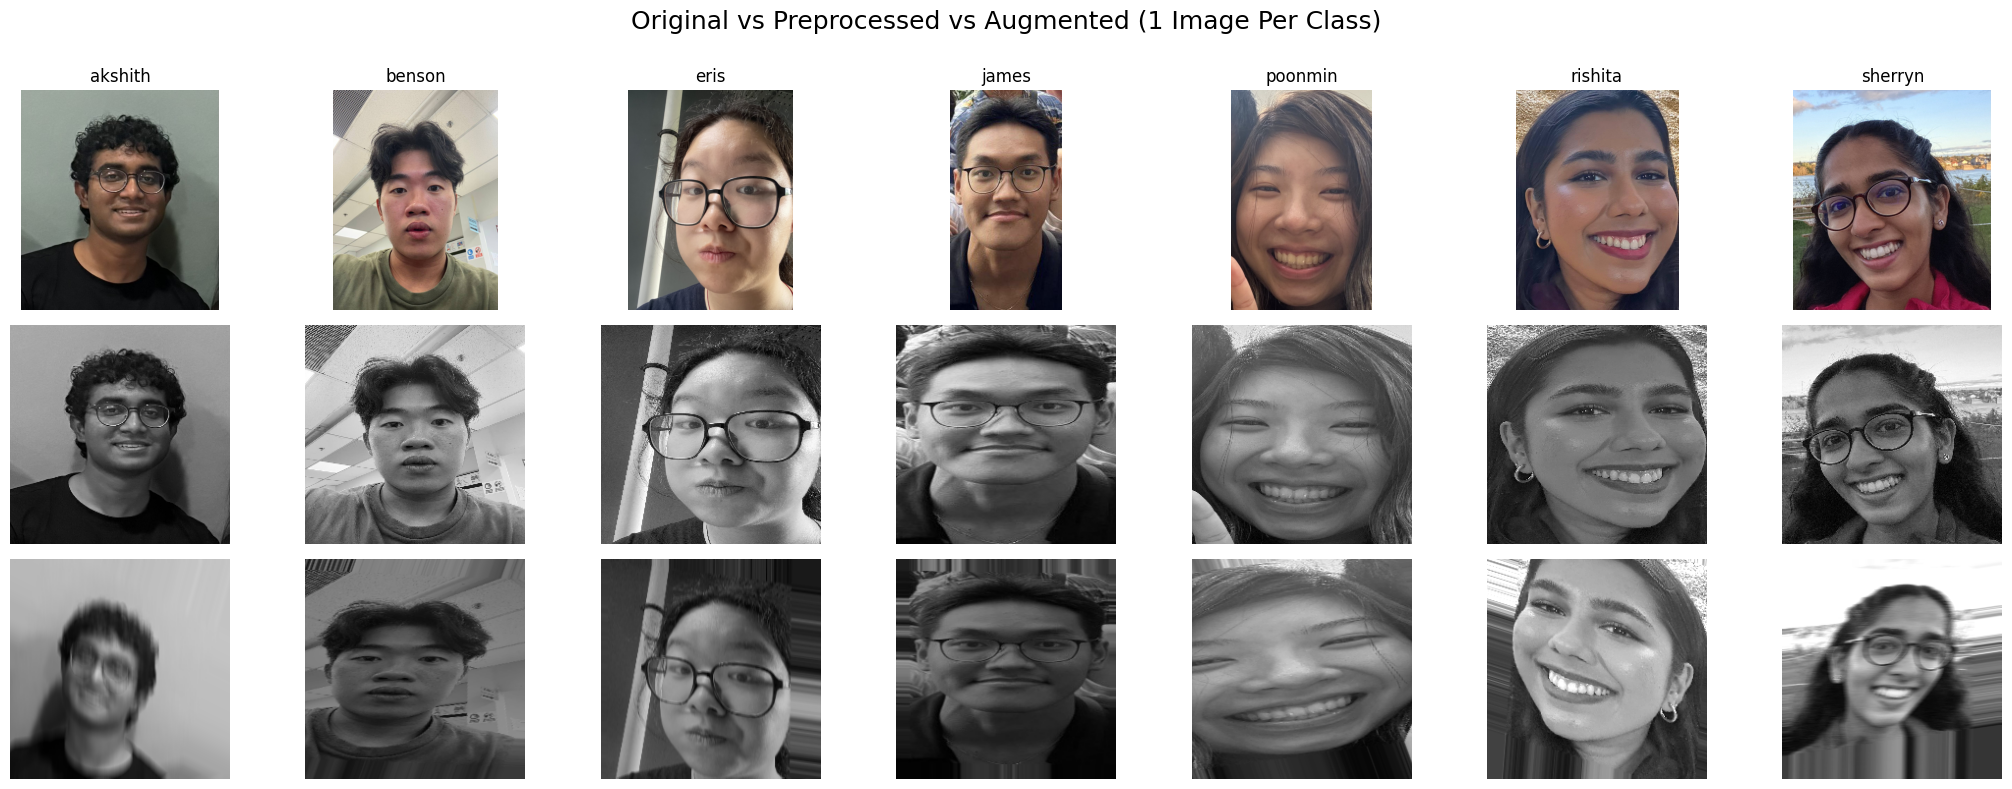

In [ ]:
# === STEP 1: Upload & Extract Dataset ===
import zipfile
import os
import shutil
from google.colab import files

# Upload ZIP
uploaded = files.upload()
ZIP_FILE = list(uploaded.keys())[0]
TEMP_ZIP_PATH = f"/content/{ZIP_FILE}"

# Save to /content
with open(TEMP_ZIP_PATH, 'wb') as f:
    f.write(uploaded[ZIP_FILE])
print(f"✅ Uploaded file saved at: {TEMP_ZIP_PATH}")

# Clear and extract
EXTRACT_PATH = "/content/extracted_data"
if os.path.exists(EXTRACT_PATH):
    shutil.rmtree(EXTRACT_PATH)
os.makedirs(EXTRACT_PATH, exist_ok=True)

with zipfile.ZipFile(TEMP_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)
print("✅ Dataset extracted!")

# Detect true folder with class dirs
def find_input_path(base_path):
    for root, dirs, _ in os.walk(base_path):
        if dirs:
            return root
    return base_path

INPUT_PATH = find_input_path(EXTRACT_PATH)
EXTRACT_PATH = INPUT_PATH  # <== set the true path for later use
print(f"✅ Using dataset path: {EXTRACT_PATH}")
print("📂 Class Folders:", os.listdir(EXTRACT_PATH))

if len(os.listdir(INPUT_PATH)) == 1:
    possible_subdir = os.path.join(INPUT_PATH, os.listdir(INPUT_PATH)[0])
    if os.path.isdir(possible_subdir):
        INPUT_PATH = possible_subdir
        EXTRACT_PATH = INPUT_PATH
        print(f"🔁 Re-entered into actual class folder directory: {EXTRACT_PATH}")

# === STEP 2: Preprocess, Augment, Visualize ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
PREPROCESSED_PATH = "/content/preprocessed_data"
AUGMENTED_PATH = "/content/augmented_data"
IMG_EXTS = (".jpg", ".jpeg", ".png")

# Clean output folders
for path in [PREPROCESSED_PATH, AUGMENTED_PATH]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

# Preprocessing: resize + grayscale
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return cv2.resize(img, IMG_SIZE)

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.3,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    fill_mode='nearest'
)

def apply_random_motion_blur(img, max_kernel_size=15):
    kernel_size = np.random.choice(range(3, max_kernel_size, 2))
    direction = np.random.choice(['horizontal', 'vertical', 'diagonal1', 'diagonal2'])
    kernel = np.zeros((kernel_size, kernel_size))
    if direction == 'horizontal':
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    elif direction == 'vertical':
        kernel[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    elif direction == 'diagonal1':
        np.fill_diagonal(kernel, 1)
    elif direction == 'diagonal2':
        np.fill_diagonal(np.fliplr(kernel), 1)
    return cv2.filter2D(img, -1, kernel / kernel_size)

# Process each class
class_names = sorted([
    d for d in os.listdir(EXTRACT_PATH)
    if os.path.isdir(os.path.join(EXTRACT_PATH, d))
])

for class_name in class_names:
    orig_dir = os.path.join(EXTRACT_PATH, class_name)
    preproc_dir = os.path.join(PREPROCESSED_PATH, class_name)
    augment_dir = os.path.join(AUGMENTED_PATH, class_name)
    os.makedirs(preproc_dir, exist_ok=True)
    os.makedirs(augment_dir, exist_ok=True)

    image_files = [f for f in os.listdir(orig_dir) if f.lower().endswith(IMG_EXTS)]
    if not image_files:
        print(f"⚠️ Skipping {class_name}: no valid image found.")
        continue

    img_path = os.path.join(orig_dir, image_files[0])

    # Preprocess (grayscale + resize)
    pre_img = preprocess_image(img_path)
    if pre_img is not None:
        cv2.imwrite(os.path.join(preproc_dir, "preprocessed.png"), pre_img)

    # Augment (grayscale)
    img_gray = preprocess_image(img_path)  # resize + grayscale
    if img_gray is not None:
        img_gray_exp = np.expand_dims(img_gray, axis=(0, -1))  # shape: (1, 224, 224, 1)
        batch = next(datagen.flow(img_gray_exp, batch_size=1))
        aug_img = batch[0].astype(np.uint8).squeeze()

        # Apply motion blur (still works in grayscale)
        if np.random.rand() < 0.5:
            aug_img = apply_random_motion_blur(aug_img)

        # Save as grayscale
        cv2.imwrite(os.path.join(augment_dir, "augmented.png"), aug_img)

# === STEP 3: Display with Matplotlib ===
def show_three_column_images(title, orig_path, preproc_path, augment_path):
    class_names = sorted([
        d for d in os.listdir(orig_path)
        if os.path.isdir(os.path.join(orig_path, d))
           and any(f.lower().endswith(IMG_EXTS) for f in os.listdir(os.path.join(orig_path, d)))
    ])

    if not class_names:
        print("🚫 No valid classes found.")
        return

    fig, axes = plt.subplots(3, len(class_names), figsize=(3 * len(class_names), 8))
    fig.suptitle(title, fontsize=18)

    for col, class_name in enumerate(class_names):
        # === 1. Original ===
        orig_img_file = next((f for f in os.listdir(os.path.join(orig_path, class_name)) if f.lower().endswith(IMG_EXTS)), None)
        if orig_img_file:
            orig_img = cv2.imread(os.path.join(orig_path, class_name, orig_img_file))
            axes[0, col].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
            axes[0, col].set_title(class_name)
        else:
            axes[0, col].text(0.5, 0.5, "Missing", ha="center", va="center")
        axes[0, col].axis("off")

        # === 2. Preprocessed ===
        pre_img_path = os.path.join(preproc_path, class_name, "preprocessed.png")
        if os.path.exists(pre_img_path):
            pre_img = cv2.imread(pre_img_path, cv2.IMREAD_GRAYSCALE)
            axes[1, col].imshow(pre_img, cmap="gray")
        else:
            axes[1, col].text(0.5, 0.5, "Missing", ha="center", va="center")
        axes[1, col].axis("off")

        # === 3. Augmented ===
        aug_img_path = os.path.join(augment_path, class_name, "augmented.png")
        if os.path.exists(aug_img_path):
            aug_img = cv2.imread(aug_img_path)
            axes[2, col].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        else:
            axes[2, col].text(0.5, 0.5, "Missing", ha="center", va="center")
        axes[2, col].axis("off")

    # Add labels to the rows
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Preprocessed", fontsize=12)
    axes[2, 0].set_ylabel("Augmented", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Run the display
show_three_column_images(
    title="Original vs Preprocessed vs Augmented (1 Image Per Class)",
    orig_path=EXTRACT_PATH,
    preproc_path=PREPROCESSED_PATH,
    augment_path=AUGMENTED_PATH
)


In [ ]:
import shutil
from google.colab import files

# Zip the final augmented dataset
shutil.make_archive("/content/augmented_dataset", 'zip', "/content/augmented_dataset")

# Download it to your local machine
files.download("/content/augmented_dataset.zip")

print("✅ Download the processed (augmented) dataset from Colab.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download the processed (augmented) dataset from Colab.
